### Importing Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

### Creating Dataset

In [26]:
X, y = make_friedman1(n_samples=150000, n_features=10, noise=0.0, random_state=42) #generating dataset for regression target
features = [f'Feature {x}' for x in range(1, 11)]
ds = pd.DataFrame(X, columns=features)
ds['Regression Target'] = y

print(ds.head(10))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #splitting up data

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0   0.374540   0.950714   0.731994   0.598658   0.156019   0.155995   
1   0.020584   0.969910   0.832443   0.212339   0.181825   0.183405   
2   0.611853   0.139494   0.292145   0.366362   0.456070   0.785176   
3   0.607545   0.170524   0.065052   0.948886   0.965632   0.808397   
4   0.122038   0.495177   0.034389   0.909320   0.258780   0.662522   
5   0.969585   0.775133   0.939499   0.894827   0.597900   0.921874   
6   0.388677   0.271349   0.828738   0.356753   0.280935   0.542696   
7   0.772245   0.198716   0.005522   0.815461   0.706857   0.729007   
8   0.863103   0.623298   0.330898   0.063558   0.310982   0.325183   
9   0.119594   0.713245   0.760785   0.561277   0.770967   0.493796   

   Feature 7  Feature 8  Feature 9  Feature 10  Regression Target  
0   0.058084   0.866176   0.601115    0.708073          16.838262  
1   0.304242   0.524756   0.431945    0.291229           5.869689  
2   0.199674  

### Creating and Training Linear Regression Model

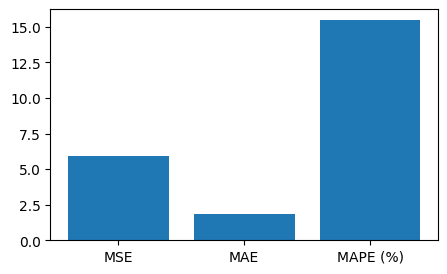

MSE = 5.90342
MAE = 1.86546
MAPE (%) = 15.458


In [27]:
def linear_regression_model(X_train, y_train, X_test, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    mse = round(mean_squared_error(y_test, y_pred), 5) #evaluating errors
    mae = round(mean_absolute_error(y_test, y_pred), 5)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)

    names = ['MSE', 'MAE', 'MAPE (%)']
    values = [mse, mae, mape * 100]

    plt.figure(figsize=(5, 3))
    plt.bar(names, values)
    plt.show()
    
    for x in range(3):
        print(f'{names[x]} = {values[x]}')
    
    return lr

lr = linear_regression_model(X_train, y_train, X_test, y_test)

### Showing learning curve

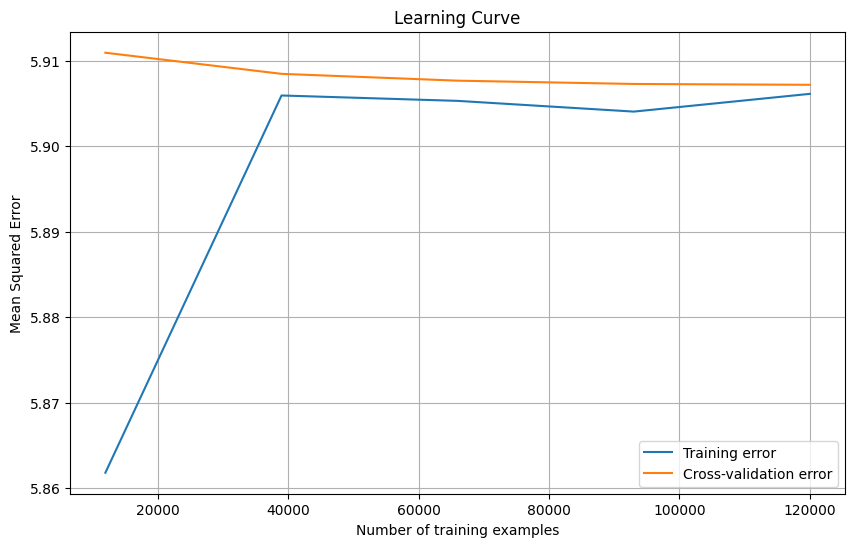

In [28]:
def lr_plot_learning_curve(estimator, X, y): # defining function to plot learning curves
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
    
    plt.xlabel('Number of training examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
lr_plot_learning_curve(lr, X, y)

### Creating DNN model for regression

In [77]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class DenseNeuralNetwork(nn.Module): # creating dnn model using pytorch
    def __init__(self, input_size, layers):
        super(DenseNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.layers = layers
        self.fc_layers = nn.ModuleList()
        for _ in range(layers):
            self.fc_layers.append(nn.Linear(self.input_size, 64))
            self.fc_layers.append(nn.ReLU())
            self.input_size = 64
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        for layer in self.fc_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

def train_and_evaluate_model(X_train, X_test, y_train, y_test, layers, optimizer, learning_rate):
    try:
        model = DenseNeuralNetwork(input_size=X_train.shape[1], layers=layers)
        criterion = nn.MSELoss()
        if optimizer == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer == 'RMSProp':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        elif optimizer == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        else:
            raise ValueError("Invalid optimizer")

        history = {'loss': [], 'val_loss': []} # running on 50 epochs 
        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train_tensor)
            loss = criterion(y_pred, y_train_tensor.view(-1, 1))
            loss.backward()
            optimizer.step()
            history['loss'].append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred_val = model(X_test_tensor)
                val_loss = criterion(y_pred_val, y_test_tensor.view(-1, 1))
                history['val_loss'].append(val_loss.item())

        y_pred = model(X_test_tensor).detach().numpy()
        if np.isnan(y_pred).any():
            raise ValueError("NaN values encountered in predictions.")
        else: 
            r2 = r2_score(y_test, y_pred) # returning scores
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            print("Successfully computed metrics.")
            return history, r2, mae, mape, mse

    except ValueError as e:
        print(f"Error occurred: {e}")
        return history, None, None, None, None # return the metrics computed up to this point





Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.
Successfully computed metrics.


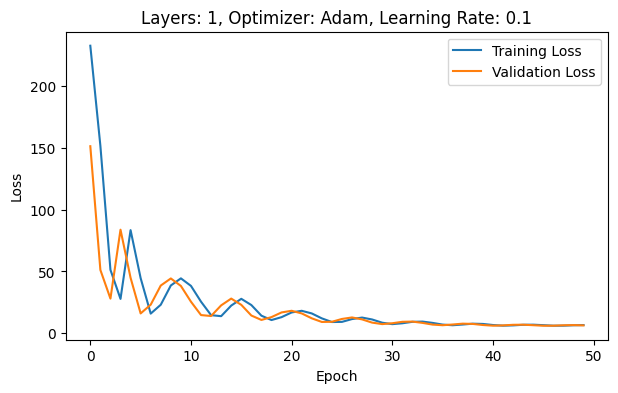

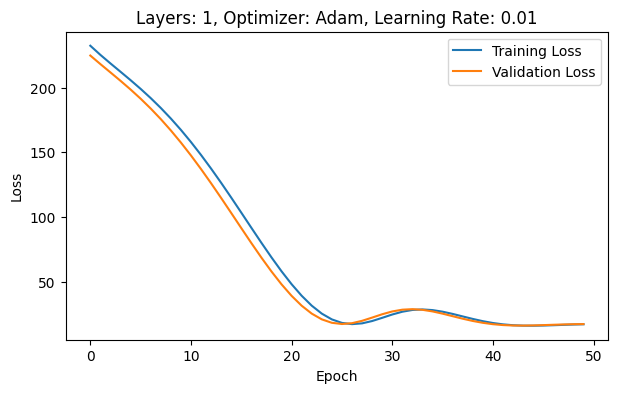

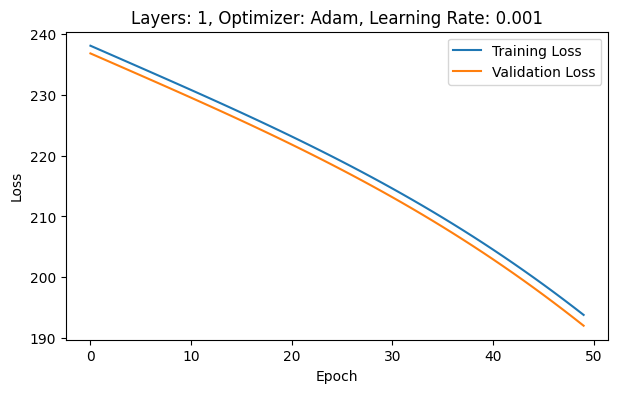

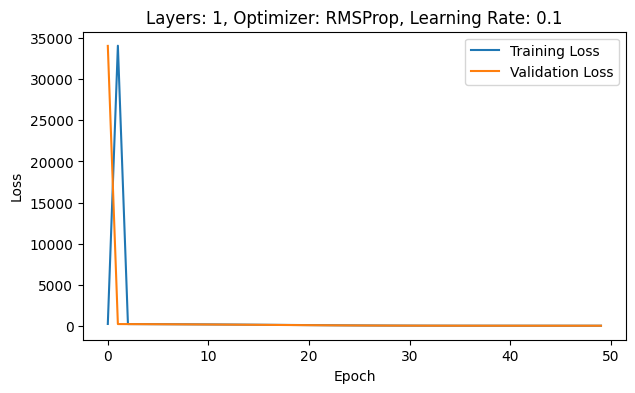

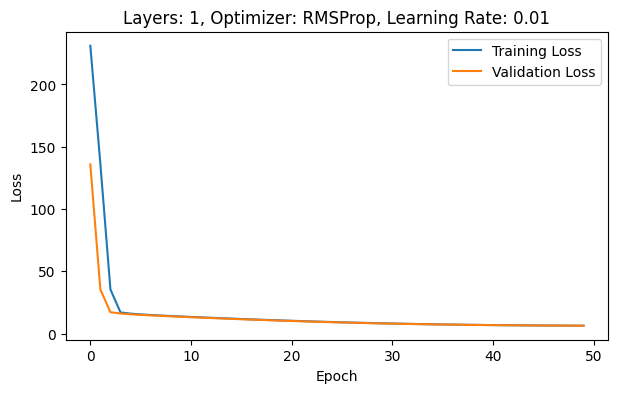

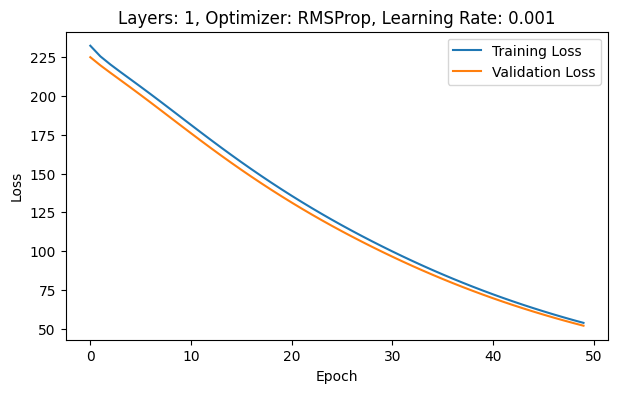

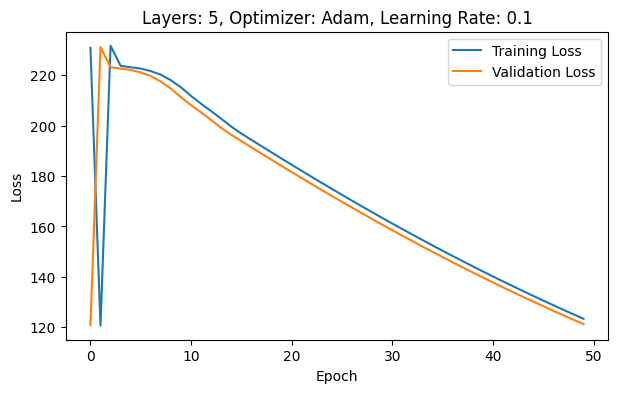

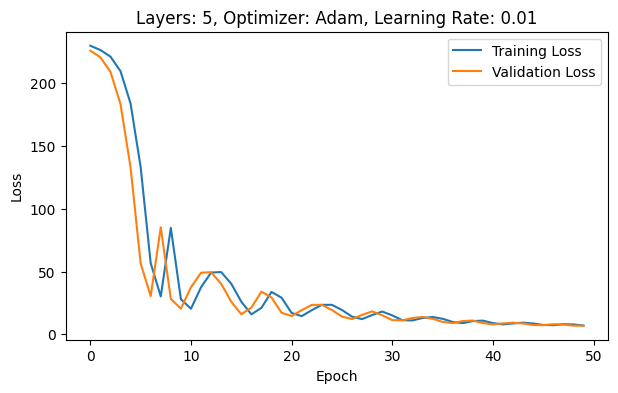

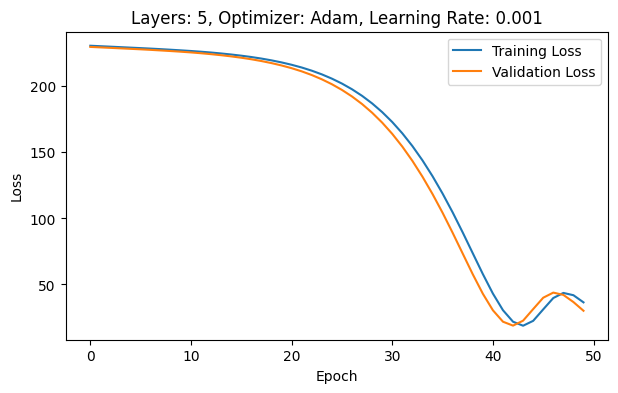

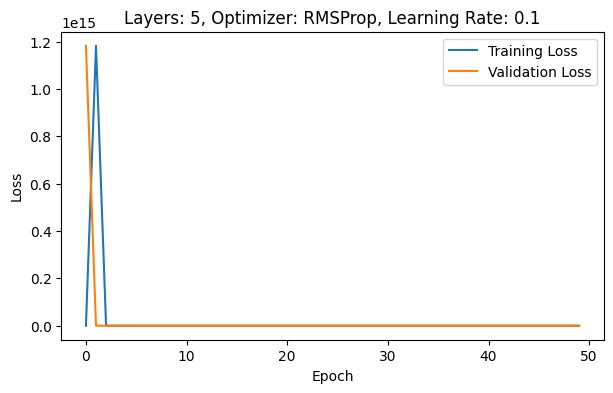

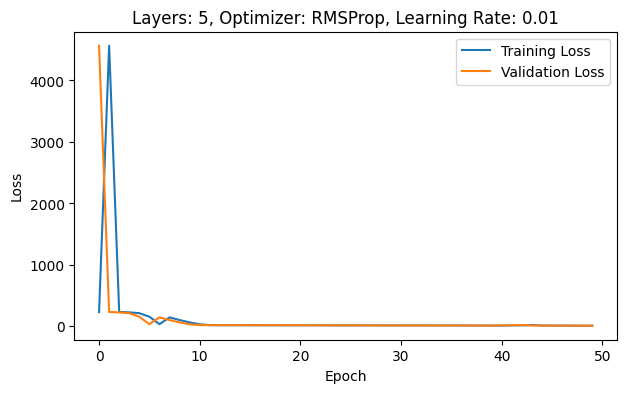

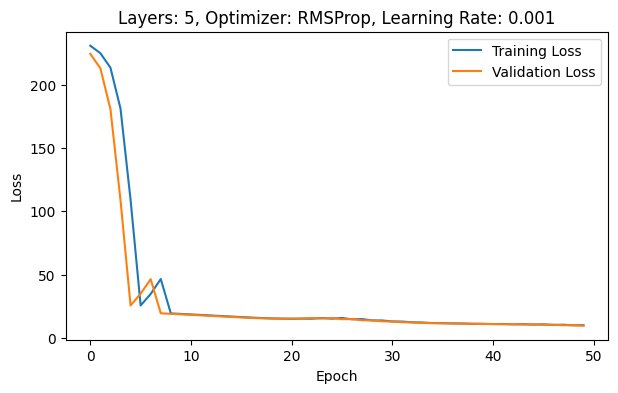

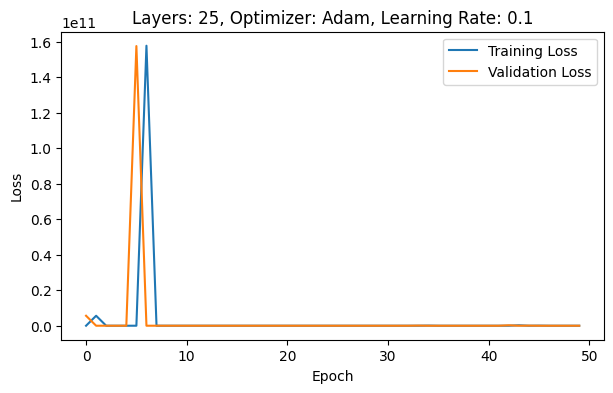

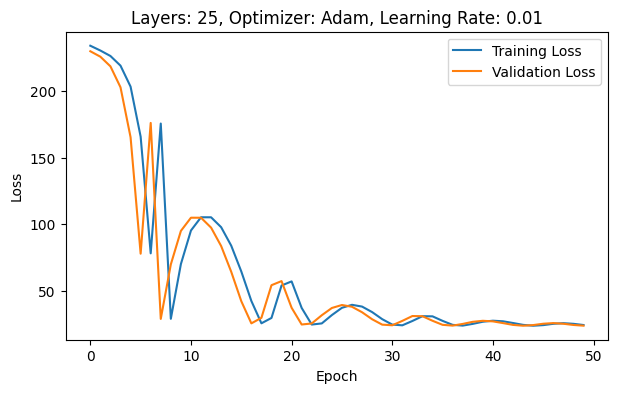

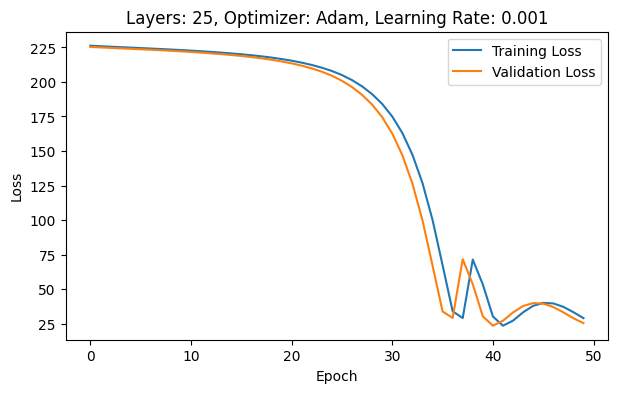

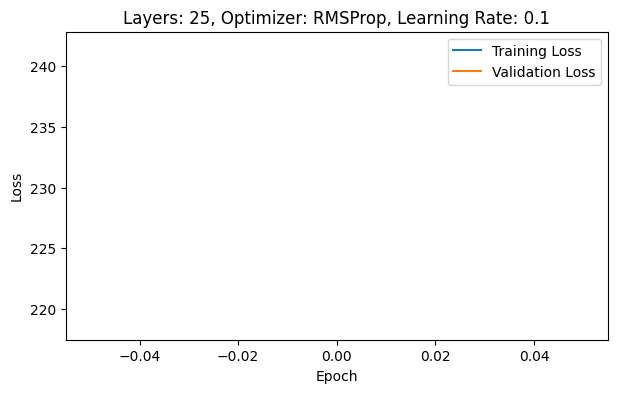

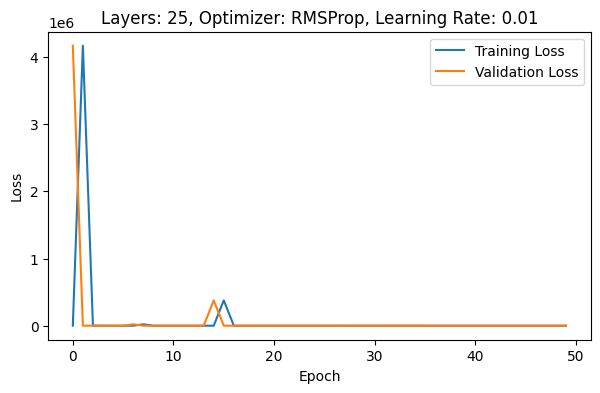

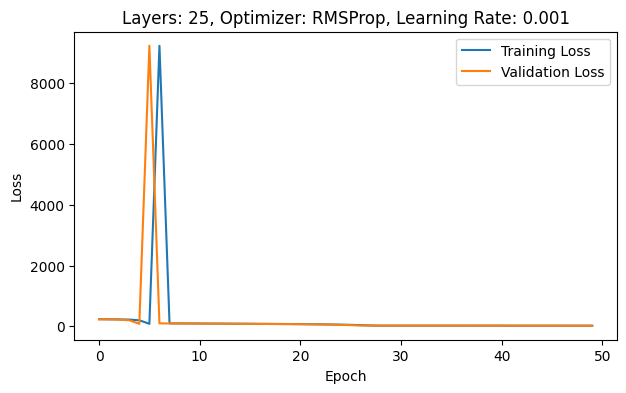

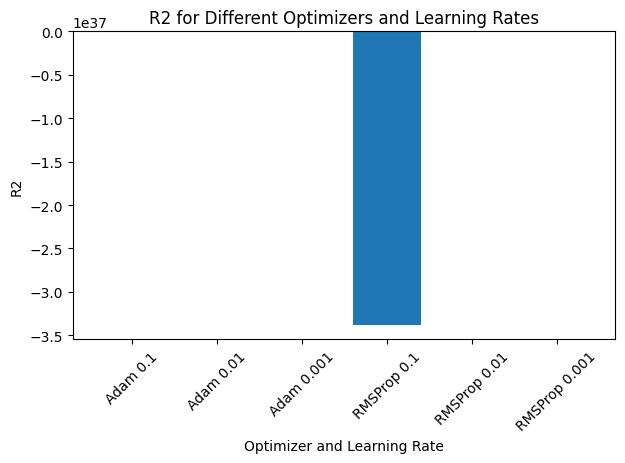

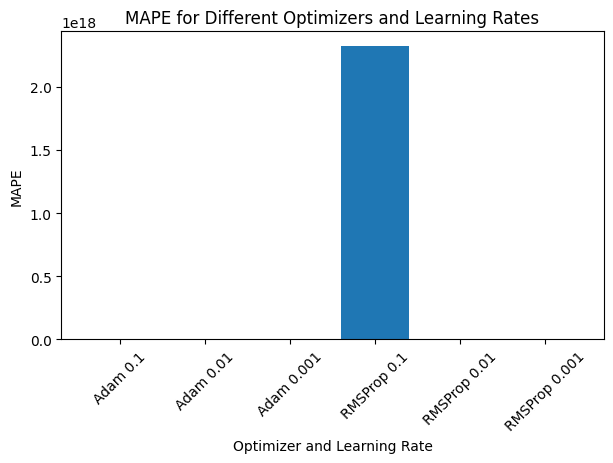

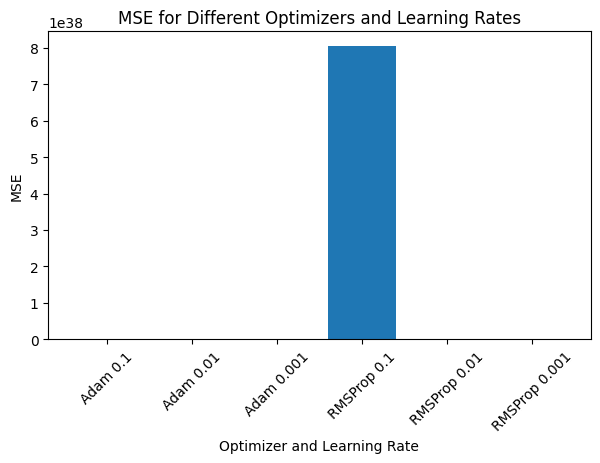

    Layers Optimizer  Learning Rate            R2           MAE          MAPE  \
0        1      Adam          0.100  7.324057e-01  1.928147e+00  1.691973e-01   
1        1      Adam          0.010  2.815919e-01  3.334214e+00  2.767489e-01   
2        1      Adam          0.001 -7.064576e+00  1.301591e+01  8.924232e-01   
3        1   RMSProp          0.100  3.009062e-01  3.305973e+00  3.063237e-01   
4        1   RMSProp          0.010  7.377173e-01  1.960648e+00  1.699698e-01   
5        1   RMSProp          0.001 -1.180729e+00  6.098891e+00  3.951533e-01   
6        5      Adam          0.100 -4.088901e+00  9.903063e+00  6.445085e-01   
7        5      Adam          0.010  7.111799e-01  2.099361e+00  1.834323e-01   
8        5      Adam          0.001 -2.645961e-01  4.491139e+00  4.724217e-01   
9        5   RMSProp          0.100 -8.833328e+00  1.450371e+01  1.009544e+00   
10       5   RMSProp          0.010  5.545824e-01  2.613057e+00  2.597162e-01   
11       5   RMSProp        

In [79]:
layers_list = [1, 5, 25]  # perform hyperparameter
optimizer_list = ['Adam', 'RMSProp']
learning_rate_list = [0.1, 0.01, 0.001]

results = []
for layers in layers_list: # running for all of layer amount, learning rate combinations and optimizers
    for optimizer in optimizer_list:
        for learning_rate in learning_rate_list:
            history, r2, mae, mape, mse = train_and_evaluate_model(X_train, X_test, y_train, y_test, layers, optimizer, learning_rate)
            results.append({'Layers': layers, 'Optimizer': optimizer, 'Learning Rate': learning_rate,
                        'R2': r2, 'MAE': mae, 'MAPE': mape, 'MSE': mse, 'History': history})
        
for result in results: # ploting results
    plt.figure(figsize=(7, 4))
    plt.plot(result['History']['loss'], label='Training Loss')
    plt.plot(result['History']['val_loss'], label='Validation Loss')
    plt.title(f"Layers: {result['Layers']}, Optimizer: {result['Optimizer']}, Learning Rate: {result['Learning Rate']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

metrics_ds = pd.DataFrame(results)
for metric in ['R2', 'MAPE', 'MSE']:
    plt.figure(figsize=(7, 4))
    plt.bar(metrics_ds['Optimizer'] + ' ' + metrics_ds['Learning Rate'].astype(str), metrics_ds[metric])
    plt.title(f'{metric} for Different Optimizers and Learning Rates')
    plt.xlabel('Optimizer and Learning Rate')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

print(metrics_ds)

### Conclusions

Отже при виконанні даної лабораторної роботи можна сказати, що найкращі результати, для мого датасету, демонструє DNN з найбільшою кількістю шарів та оптимайзером Adam. На великих навчальних темпах (learning rate) Rms може повертати Nan, що спричиняє помилку в подальшій роботі моделі.

Загалом можна вважати, що DNN має більший потенціал за звичайну регресію, при більшій кількості шарів та правильній конфігурації таких гіперпараметрів як learning_rate, optimizer. Коротко кажучи при наявності більшої обчислювальної потужності - варто застосовувати DNN, а у випадку нестачі таких ресурсів, можна застосовувати й звичайну лінійну регресію.

Також, при запуску тестування та тренування моделі виявив, що деякі оптимайзери, чи помилки - повертають Not A Number значення. Про це питали на лекції, і як варіант казали про ігнорування таких помилок. Отож, аби це захендлети в помістив тренування та повертання резульатів у try catch блок, де у випадку помилки, я просто повертаю None. Така помилка виникала при лише одній комбінації гіперпараметрів (порожній графік вище). Отже цей графік залишив просто порожнім. 